In [1]:
# Characterize germline insertions

In [217]:
from collections import (
    defaultdict,
    namedtuple,
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import seaborn as sns


PAIRS = {
    'H1': 'H3',
    'H4': 'H6',
    'H7': 'H9',
    'R1': 'R2',
    'R3': 'R4',
    'R5': 'R6',
    'R7': 'R8',
    'R9': 'R10',
    'R11': 'R12',
    'R13': 'R14',
    'R15': 'R16',
    'R17': 'R18',
    'R19': 'R20',
    'R21': 'R22',
    'R23': 'R24',
    'R25': 'R26',
    'R27': 'R28',
    'R29': 'R30',
    'R31': 'R32',
    'R33': 'R34',
    'R35': 'R36',
    'R37': 'R38',
    'R39': 'R40',
    'R41A': 'R42A',
    'R41B': 'R42B',
    'R43': 'R44',
    'R45': 'R46',
    'R47': 'R48',
    'R49': 'R50',
    'R51': 'R52',
    'R53': 'R54',
    'R55': 'R56',
    'R57': 'R58',
    'R59': 'R60',
    'R61': 'R62',
    'R63': 'R64',
}
PAIRS.update({v:k for k,v in PAIRS.items()})


COLUMNS = ['chrom', 'program', 'insertion', 'start', 'end', 'score', 'strand', 'idk', 'attributes']
insertion = namedtuple('Insertion', COLUMNS)

In [260]:
PUTATIVE_INSERTIONS = '../../pre-processed-data/raw_insertion_calls/all_putative_germline_insertions.gff3'
# PUTATIVE_INSERTIONS = '../../pre-processed-data/insertion_calls/coverage/combined_sorted_somatic_insertions.gff'
COVERAGE_FILE = '../../pre-processed-data/raw_insertion_calls/coverage_over_germline_insertions.tsv'
# COVERAGE_FILE = '../../pre-processed-data/insertion_calls/coverage/d'
ALL_INSERTIONS = '/Users/mvandenb/Downloads/Galaxy1199-[Concatenate_multiple_datasets_on_data_1198,_data_1197,_and_others].gff3'
# ALL_INSERTIONS = PUTATIVE_INSERTIONS
SOMATIC_DATA = ['../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_guts.gff', '../../pre-processed-data/insertion_calls/0.5.21.filtered_calls_prosgfp_heads.gff']
INSERTION_SUMMARY = 'All somatic TSD insertions.tsv'
FINAL_TABLE = 'Final somatic table.tsv'

In [261]:
summary = namedtuple('summary', 'chrom start mate_support split_support nref vaf')


def read_insertions(path):
    all_inserts = defaultdict(list)
    with open(path) as in_fh:
        for line in in_fh:
            fields = line.split()
            chrom = fields[0]
            start = int(fields[3])
            attributes = dict(item.split("=") for item in fields[8].split(";"))
            mate_support = int(attributes['left_mate_count']) + int(attributes['right_mate_count'])
            total_support = int(attributes['total_left_count']) + int(attributes['total_right_count'])
            split_support = total_support - mate_support
            nref = int(attributes['nref'])
            vaf = total_support / (total_support + nref)
            all_inserts[attributes['ID']].append((summary(chrom, start, mate_support, split_support, nref, vaf)))
    return all_inserts

all_inserts = read_insertions(ALL_INSERTIONS)

In [262]:
def find_overlap_support(all_inserts, cluster_id, chrom, start):
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.mate_support, insert.split_support
    return 0, 0

def find_nref(all_inserts, cluster_id, chrom, start):
    # nref = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.nref
    return 0

def find_vaf(all_inserts, cluster_id, chrom, start):
    # vaf = []
    for insert in all_inserts[cluster_id]:
        if insert.chrom == chrom and abs(insert.start - int(start)) < 500:
            return insert.vaf
    return 0

In [263]:
def summarize_overlaps(insertions):
    overlaps = set()
    cluster_ids = set()
    if not insertions:
        raise Exception('nope')
    for index, ins in enumerate(insertions):
        overlaps.add(ins.attributes['ID'].split('_')[0])
        cluster_ids.add(ins.attributes['ID'])
        for overlap in ins.attributes['overlaps'].split(','):
            if overlap:
                cluster_ids.add(overlap)
                overlaps.add(overlap.split('_')[0])
        is_somatic  = (ins.chrom, ins.start, ins.end, ins.insertion) in somatic
    return [index, ins.chrom, ins.start, ins.end, ins.insertion, ins.strand, is_somatic, len(overlaps), cluster_ids]


def get_insertions_by_coordinate(path):
    insertions_by_coordinate = defaultdict(list)
    with open(path) as fh:
        for line in fh:
            fields = line.strip().split('\t')
            fields[8] = dict(item.split("=") for item in fields[8].split(";"))
            ins = insertion(*fields)
            if ins.attributes['valid_TSD'] == 'True':
                insertions_by_coordinate[(ins.chrom, ins.start, ins.end, ins.insertion)].append(ins)
    return insertions_by_coordinate


insertions_by_coordinate = get_insertions_by_coordinate(PUTATIVE_INSERTIONS)


somatic = defaultdict(list)
for dataset in SOMATIC_DATA:
    somatic.update(get_insertions_by_coordinate(dataset))

somatic = {ins: summarize_overlaps(somatic[ins]) for ins in somatic}

In [264]:
len(insertions_by_coordinate)

3650

In [265]:
possible_somatic = {k:v for k, v in insertions_by_coordinate.items() if sum(1 for _ in v if _.attributes['overlaps'].count(',') == 0) == len(v)}

In [266]:
len(possible_somatic)

476

In [267]:
possible_private = defaultdict(list)

for insertions in insertions_by_coordinate.values():
    for record in insertions:
        overlaps = [overlap.split('_')[0] for overlap in record.attributes['overlaps'].split(',')]
        if len(overlaps) == 2 and PAIRS[overlaps[0]] == overlaps[1] and record.attributes['valid_TSD'] == 'True':
            possible_private[(record.chrom, record.start, record.end, record.insertion)].append(record)

In [268]:
early_somatic = {k:v for k,v in possible_private.items() if len(v) == 1}

In [269]:
private = {k:v for k,v in possible_private.items() if len(v) == 2}

In [270]:
def merge_connected_clusters(shared_summary):
    new_summary = []
    n_insertions = len(shared_summary)
    skip = -1
    for i, s in enumerate(shared_summary):
        if not skip == i:
            if i < (n_insertions - 1):
                n_s = shared_summary[i + 1]
                if s[-1] & n_s[-1]:
                    s[-1] = s[-1].union(n_s[-1])
                    skip = i + 1
            s[-2] = len(set(overlap.split('_')[0] for overlap in s[-1]))
            new_summary.append(s)
    return new_summary

<AxesSubplot:xlabel='Number of samples with insertion', ylabel='Number of insertion'>

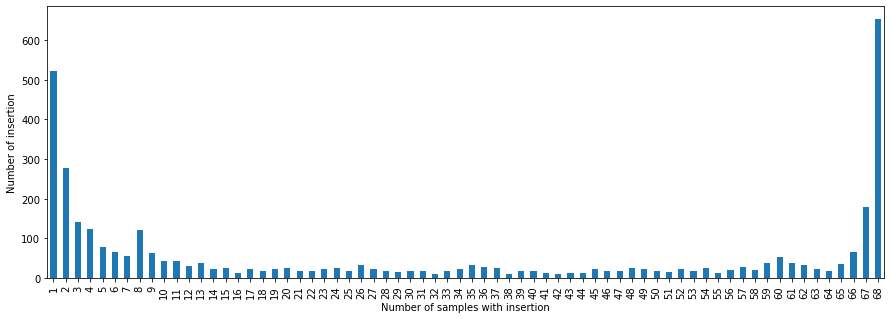

In [271]:
shared_germline = set(insertions_by_coordinate.keys()) - set(possible_somatic.keys()) - set(private.keys())
shared_summary = [summarize_overlaps(insertions_by_coordinate[ins]) for ins in insertions_by_coordinate]

# Make that a recursive call
new_summary = merge_connected_clusters(shared_summary)
new_summary = merge_connected_clusters(list(reversed(new_summary)))
new_summary = merge_connected_clusters(new_summary)
new_summary = list(reversed(merge_connected_clusters(list(reversed(new_summary)))))

shared_df = pd.DataFrame.from_records(shared_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps',]
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion")

<AxesSubplot:xlabel='Number of samples with insertion, merge aggressively', ylabel='Number of insertion'>

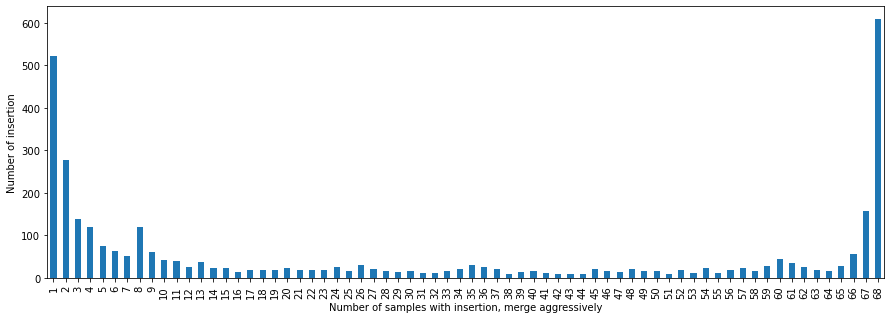

In [272]:
shared_df = pd.DataFrame.from_records(new_summary)
shared_df.columns = ['index', 'chrom', 'start', 'end', 'insertion', 'strand', 'somatic', 'N_samples', 'overlaps']
shared_df['support'] = shared_df.apply(lambda row: [find_overlap_support(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['nref'] = shared_df.apply(lambda row: [find_nref(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
shared_df['vaf'] = shared_df.apply(lambda row: [find_vaf(all_inserts, overlap, row['chrom'], row['start']) for overlap in row['overlaps']], axis=1)
# shared_df = shared_df[shared_df.somatic == False]
shared_df.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively")

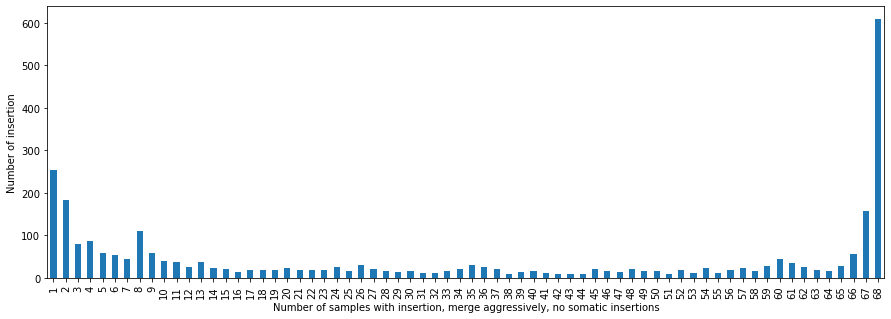

In [273]:
shared_df.somatic = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in somatic, axis=1)
shared_df['private'] = shared_df.apply(lambda row: (row.chrom, row.start, row.end, row.insertion) in possible_private, axis=1)
shared_df.somatic.value_counts()
no_somatic = shared_df[shared_df.somatic == False]
if not no_somatic.empty:
    no_somatic.N_samples.value_counts().sort_index().plot(kind='bar', figsize=(15, 5), ylabel="Number of insertion", xlabel="Number of samples with insertion, merge aggressively, no somatic insertions")

In [274]:
shared_df[(shared_df.somatic == False) & (shared_df.N_samples == 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
17,0,Y,3280194,3280204,Tabor,+,False,1,{H6_head_157},"[(18, 11)]",[65],[0.30851063829787234],False
36,0,Y,2925008,2925024,mdg1,+,False,1,{H4_gut_255},"[(7, 3)]",[16],[0.38461538461538464],False
42,0,Y,2742509,2742555,17.6,+,False,1,{H9_head_246},"[(2, 4)]",[28],[0.17647058823529413],False
45,0,Y,2488710,2488712,Quasimodo,+,False,1,{H7_gut_158},"[(45, 392)]",[250],[0.636098981077147],False
46,0,Y,2488690,2488712,3S18,+,False,1,{H1_gut_66},"[(40, 185)]",[184],[0.5501222493887531],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3355,0,2L,2621549,2621560,opus,+,False,1,{H1_gut_235},"[(13, 25)]",[5],[0.8837209302325582],False
3363,0,2L,2171902,2171906,copia,+,False,1,{R57_gut_100},"[(2, 4)]",[6],[0.5],False
3390,0,2L,833028,833039,BS,+,False,1,{H7_gut_1014},"[(24, 13)]",[37],[0.5],False
3391,0,2L,801430,801443,mdg1,+,False,1,{H9_head_267},"[(19, 11)]",[26],[0.5357142857142857],False


In [275]:
shared_df.strand.value_counts()

+    3402
Name: strand, dtype: int64

In [276]:
shared_df[(shared_df.somatic == False) & (shared_df.private == True)].insertion.value_counts()

hobo         34
roo          14
FB           10
copia         8
rover         6
BS            2
Tirant        2
Tabor         1
Stalker2      1
Quasimodo     1
INE-1         1
Rt1b          1
flea          1
Doc           1
Juan          1
I-element     1
pogo          1
Name: insertion, dtype: int64

In [277]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover')].N_samples.value_counts()

1     29
2     26
3     14
4     14
6      5
7      5
9      3
5      3
44     2
8      1
68     1
57     1
11     1
12     1
15     1
17     1
26     1
33     1
10     1
Name: N_samples, dtype: int64

In [278]:
shared_df[(shared_df.somatic == False) & (shared_df.insertion == 'rover') & (shared_df.N_samples == 68)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
2226,57,2R,14487743,14487748,rover,+,False,68,"{R13_gut_131, R60_head_65, R49_gut_44, R57_gut...","[(39, 33), (0, 23), (13, 18), (29, 18), (8, 22...","[53, 36, 15, 33, 32, 24, 18, 18, 26, 49, 16, 4...","[0.576, 0.3898305084745763, 0.6739130434782609...",False


In [279]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R32_head_221, R46_head_259, R45_gut_180, R33_...","[(48, 2), (0, 0), (1, 0), (1, 0), (1, 0), (0, ...","[114, 0, 27, 61, 11, 0, 6, 0, 0, 87, 91, 74]","[0.3048780487804878, 0, 0.03571428571428571, 0...",False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R1_gut_374, R39_gut_243, R18_he...","[(76, 35), (14, 60), (19, 13), (2, 0), (13, 15...","[0, 1, 0, 7, 7, 1, 0, 1, 3, 0]","[1.0, 0.9866666666666667, 1.0, 0.2222222222222...",False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R38_head_239, R3_gut_468, R54_head_233, H3_he...","[(29, 25), (25, 73), (28, 20), (26, 35), (22, ...","[16, 1, 0, 0, 1, 3, 2, 16, 2, 7, 3, 3, 2]","[0.7714285714285715, 0.98989898989899, 1.0, 1....",False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R43_gut_325, R42A_head_213, R41B_gut_126, R28...","[(16, 18), (18, 17), (3, 1), (19, 53), (5, 17)...","[0, 0, 0, 5, 1, 0, 2, 2, 0, 1, 1, 0, 0, 6, 0, 2]","[1.0, 1.0, 1.0, 0.935064935064935, 0.956521739...",False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R59_gut_251, R64_head_280, H4_gut_269, R53_gu...","[(12, 7), (20, 13), (23, 30), (0, 0), (19, 12)...","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 5, 0, 0, ...","[1.0, 0.9166666666666666, 1.0, 0, 1.0, 1.0, 1....",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R29_gut_31, R5_gut_44, R37_gut_12, R11_gut_23...","[(24, 38), (0, 0), (1, 0), (1, 0), (1, 0), (3,...","[92, 0, 110, 154, 151, 102, 104, 0, 156, 38, 1...","[0.4025974025974026, 0, 0.009009009009009009, ...",False
3398,1,2L,171710,171713,springer,+,False,3,"{H7_gut_238, H9_head_74, R1_gut_105}","[(19, 26), (44, 26), (6, 0)]","[16, 37, 102]","[0.7377049180327869, 0.6542056074766355, 0.055...",False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",[73],[0.7245283018867924],False
3400,60,2L,140056,140060,roo,+,False,67,"{H7_gut_186, R58_head_14, R49_gut_17, R24_head...","[(0, 1), (40, 27), (30, 16), (16, 27), (103, 3...","[83, 21, 18, 12, 53, 16, 5, 39, 18, 125, 57, 2...","[0.011904761904761904, 0.7613636363636364, 0.7...",False


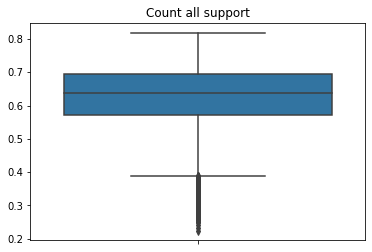

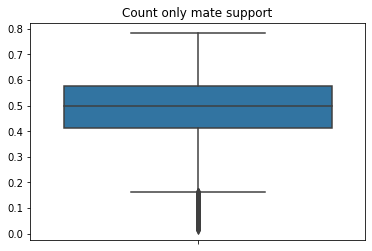

In [280]:
fully_penetrant = shared_df[shared_df.N_samples == 68]
x = fully_penetrant[['chrom', 'start', 'end', 'insertion']]
y = [insertions_by_coordinate[tuple(r)] for r in x.to_records(index=False)]

if not fully_penetrant.empty:
    # All support
    ratio = []
    x_insertions = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                if ins.chrom == 'X':
                    x_insertions.append(ins)
                nref = int(ins.attributes['nref'])
                score = int(ins.score)
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count all support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))
    # Mate support
    ratio = []
    plt.figure()
    for insertions in y[50:]:
        for ins in insertions:
            if ins.attributes['genotype'] == 'heterozygous' and int(ins.score) > 15:
                nref = int(ins.attributes['nref'])
                score = int(ins.attributes['left_mate_count']) + int(ins.attributes['right_mate_count'])
                ratio.append(score /  (score + nref))
    sns.boxplot(pd.Series(ratio), orient='v').set_title("Count only mate support")
    (np.percentile(ratio, q=1), np.percentile(ratio, q=99))

In [281]:
shared_df

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R32_head_221, R46_head_259, R45_gut_180, R33_...","[(48, 2), (0, 0), (1, 0), (1, 0), (1, 0), (0, ...","[114, 0, 27, 61, 11, 0, 6, 0, 0, 87, 91, 74]","[0.3048780487804878, 0, 0.03571428571428571, 0...",False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R1_gut_374, R39_gut_243, R18_he...","[(76, 35), (14, 60), (19, 13), (2, 0), (13, 15...","[0, 1, 0, 7, 7, 1, 0, 1, 3, 0]","[1.0, 0.9866666666666667, 1.0, 0.2222222222222...",False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R38_head_239, R3_gut_468, R54_head_233, H3_he...","[(29, 25), (25, 73), (28, 20), (26, 35), (22, ...","[16, 1, 0, 0, 1, 3, 2, 16, 2, 7, 3, 3, 2]","[0.7714285714285715, 0.98989898989899, 1.0, 1....",False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R43_gut_325, R42A_head_213, R41B_gut_126, R28...","[(16, 18), (18, 17), (3, 1), (19, 53), (5, 17)...","[0, 0, 0, 5, 1, 0, 2, 2, 0, 1, 1, 0, 0, 6, 0, 2]","[1.0, 1.0, 1.0, 0.935064935064935, 0.956521739...",False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R59_gut_251, R64_head_280, H4_gut_269, R53_gu...","[(12, 7), (20, 13), (23, 30), (0, 0), (19, 12)...","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 5, 0, 0, ...","[1.0, 0.9166666666666666, 1.0, 0, 1.0, 1.0, 1....",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R29_gut_31, R5_gut_44, R37_gut_12, R11_gut_23...","[(24, 38), (0, 0), (1, 0), (1, 0), (1, 0), (3,...","[92, 0, 110, 154, 151, 102, 104, 0, 156, 38, 1...","[0.4025974025974026, 0, 0.009009009009009009, ...",False
3398,1,2L,171710,171713,springer,+,False,3,"{H7_gut_238, H9_head_74, R1_gut_105}","[(19, 26), (44, 26), (6, 0)]","[16, 37, 102]","[0.7377049180327869, 0.6542056074766355, 0.055...",False
3399,0,2L,140056,140060,opus,+,False,1,{R6_head_25},"[(139, 53)]",[73],[0.7245283018867924],False
3400,60,2L,140056,140060,roo,+,False,67,"{H7_gut_186, R58_head_14, R49_gut_17, R24_head...","[(0, 1), (40, 27), (30, 16), (16, 27), (103, 3...","[83, 21, 18, 12, 53, 16, 5, 39, 18, 125, 57, 2...","[0.011904761904761904, 0.7613636363636364, 0.7...",False


In [282]:
shared_df.somatic.value_counts()

False    2901
True      501
Name: somatic, dtype: int64

In [283]:
shared_df.N_samples.value_counts()

68    608
1     522
2     277
67    158
3     138
     ... 
43     10
42     10
51     10
38      9
44      9
Name: N_samples, Length: 68, dtype: int64

In [284]:
shared_df[(shared_df.somatic == True) & (shared_df.N_samples > 1)]

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private
130,0,X,22835722,22835727,copia,+,True,2,"{R49_gut_198, R57_gut_447}","[(1, 0), (9, 4)]","[16, 9]","[0.058823529411764705, 0.5909090909090909]",False
180,0,X,21243320,21243325,rover,+,True,5,"{R43_gut_52, R61_gut_127, R45_gut_14, H4_gut_6...","[(0, 5), (1, 0), (10, 6), (0, 1), (4, 0)]","[16, 13, 7, 53, 43]","[0.23809523809523808, 0.07142857142857142, 0.6...",False
209,0,X,19568808,19568812,rover,+,True,2,"{R61_gut_319, R39_gut_46, R39_gut_45}","[(21, 11), (0, 1), (0, 0)]","[3, 75, 0]","[0.9142857142857143, 0.013157894736842105, 0]",False
216,0,X,19335823,19335826,rover,+,True,3,"{R55_gut_26, R13_gut_63, R57_gut_116}","[(0, 0), (4, 9), (0, 1)]","[0, 15, 11]","[0, 0.4642857142857143, 0.08333333333333333]",False
257,0,X,18294955,18294960,rover,+,True,5,"{R53_gut_88, R11_gut_161, R51_gut_15, H7_gut_2...","[(10, 8), (0, 0), (0, 0), (0, 1), (2, 0), (1, 0)]","[1, 0, 0, 32, 16, 62]","[0.9473684210526315, 0, 0, 0.03030303030303030...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,0,2L,4152413,4152418,rover,+,True,3,"{R13_gut_38, R27_gut_29, R57_gut_83}","[(0, 2), (6, 16), (1, 0)]","[82, 18, 25]","[0.023809523809523808, 0.55, 0.038461538461538...",False
3378,0,2L,1446792,1446799,rover,+,True,7,"{R33_gut_135, R33_gut_137, R57_gut_233, R27_gu...","[(1, 0), (0, 1), (0, 0), (1, 0), (1, 0), (12, ...","[112, 83, 0, 68, 45, 56, 195, 39]","[0.008849557522123894, 0.011904761904761904, 0...",False
3386,0,2L,1053755,1053758,rover,+,True,3,"{R33_gut_15, R45_gut_3, R5_gut_9}","[(13, 13), (0, 1), (1, 0)]","[64, 59, 61]","[0.28888888888888886, 0.016666666666666666, 0....",False
3396,0,2L,482108,482112,rover,+,True,4,"{R39_gut_66, R33_gut_145, H4_gut_144, R39_gut_...","[(1, 0), (1, 0), (28, 10), (1, 0), (1, 0)]","[43, 60, 24, 105, 29]","[0.022727272727272728, 0.01639344262295082, 0....",False


In [285]:
pretty_summary = shared_df[['chrom', 'start', 'end', 'insertion', 'somatic', 'private', 'N_samples', 'overlaps']]

In [286]:
pretty_summary.to_csv(INSERTION_SUMMARY, sep='\t', index=None)

In [287]:
pretty_summary

,chrom,start,end,insertion,somatic,private,N_samples,overlaps
0,Y,3634227,3634257,gypsy,False,False,11,"{R32_head_221, R46_head_259, R45_gut_180, R33_..."
1,Y,3625759,3625762,gtwin,False,False,8,"{R12_head_419, R1_gut_374, R39_gut_243, R18_he..."
2,Y,3625759,3625762,HeT-A,False,False,13,"{R38_head_239, R3_gut_468, R54_head_233, H3_he..."
3,Y,3625759,3625762,Stalker3,False,False,16,"{R43_gut_325, R42A_head_213, R41B_gut_126, R28..."
4,Y,3625759,3625762,Stalker2,False,False,23,"{R59_gut_251, R64_head_280, H4_gut_269, R53_gu..."
...,...,...,...,...,...,...,...,...
3397,2L,223133,223138,rover,True,False,11,"{R29_gut_31, R5_gut_44, R37_gut_12, R11_gut_23..."
3398,2L,171710,171713,springer,False,False,3,"{H7_gut_238, H9_head_74, R1_gut_105}"
3399,2L,140056,140060,opus,False,False,1,{R6_head_25}
3400,2L,140056,140060,roo,False,False,67,"{H7_gut_186, R58_head_14, R49_gut_17, R24_head..."


In [288]:
coverage = pd.read_csv(COVERAGE_FILE, sep='\t')

final_table = pd.concat([shared_df, coverage], axis=1)
final_table['median_coverage'] = final_table.iloc[:, 10:].median(axis=1)


def high_and_low_support(list_of_tuples):
    support_one = sum(list_of_tuples[0])
    if len(list_of_tuples) == 1:
        return False
    support_two = sum(list_of_tuples[1])
    if min(support_one, support_two) < 3 and max(support_one, support_two) > 10:
        return True
    return False


final_table['early_developmental'] = (final_table['somatic'] == False) & (final_table['private'] == True) & (final_table['support'].apply(high_and_low_support))

In [289]:
final_table

,index,chrom,start,end,insertion,strand,somatic,N_samples,overlaps,support,nref,vaf,private,H1_gut,H4_gut,H7_gut,R1_gut,R3_gut,R5_gut,R7_gut,R9_gut,R11_gut,R13_gut,R17_gut,R19_gut,R21_gut,R23_gut,R25_gut,R27_gut,R29_gut,R31_gut,R33_gut,R35_gut,R37_gut,R39_gut,R43_gut,R45_gut,R49_gut,R51_gut,R53_gut,R55_gut,R57_gut,R59_gut,R61_gut,R63_gut,R41A_gut,R41B_gut,H3_head,H6_head,H9_head,R2_head,R4_head,R6_head,R8_head,R10_head,R12_head,R14_head,R18_head,R20_head,R22_head,R24_head,R26_head,R28_head,R30_head,R32_head,R34_head,R36_head,R38_head,R40_head,R44_head,R46_head,R50_head,R52_head,R54_head,R56_head,R58_head,R60_head,R62_head,R64_head,R42A_head,R42B_head,median_coverage,early_developmental
0,0,Y,3634227,3634257,gypsy,+,False,11,"{R32_head_221, R46_head_259, R45_gut_180, R33_...","[(48, 2), (0, 0), (1, 0), (1, 0), (1, 0), (0, ...","[114, 0, 27, 61, 11, 0, 6, 0, 0, 87, 91, 74]","[0.3048780487804878, 0, 0.03571428571428571, 0...",False,42,0,96,0,50,6,101,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,11,0,0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,8,10,10,0.0,False
1,2,Y,3625759,3625762,gtwin,+,False,8,"{R12_head_419, R1_gut_374, R39_gut_243, R18_he...","[(76, 35), (14, 60), (19, 13), (2, 0), (13, 15...","[0, 1, 0, 7, 7, 1, 0, 1, 3, 0]","[1.0, 0.9866666666666667, 1.0, 0.2222222222222...",False,74,58,123,55,216,83,113,94,86,123,21,17,54,46,51,67,74,44,74,18,56,76,59,49,33,54,28,43,44,49,37,41,58,27,139,115,70,71,76,133,100,142,139,289,27,28,57,43,72,83,54,70,78,85,65,54,55,66,66,43,41,41,58,40,81,49,41,41,58.0,False
2,9,Y,3625759,3625762,HeT-A,+,False,13,"{R38_head_239, R3_gut_468, R54_head_233, H3_he...","[(29, 25), (25, 73), (28, 20), (26, 35), (22, ...","[16, 1, 0, 0, 1, 3, 2, 16, 2, 7, 3, 3, 2]","[0.7714285714285715, 0.98989898989899, 1.0, 1....",False,74,58,123,55,216,83,113,94,86,123,21,17,54,46,51,67,74,44,74,18,56,76,59,49,33,54,28,43,44,49,37,41,58,27,139,115,70,71,76,133,100,142,139,289,27,28,57,43,72,83,54,70,78,85,65,54,55,66,66,43,41,41,58,40,81,49,41,41,58.0,False
3,13,Y,3625759,3625762,Stalker3,+,False,16,"{R43_gut_325, R42A_head_213, R41B_gut_126, R28...","[(16, 18), (18, 17), (3, 1), (19, 53), (5, 17)...","[0, 0, 0, 5, 1, 0, 2, 2, 0, 1, 1, 0, 0, 6, 0, 2]","[1.0, 1.0, 1.0, 0.935064935064935, 0.956521739...",False,0,0,59,93,280,0,0,0,43,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,21,0,0,0,43,0,63,0,63,0,0,13,0,179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,0,0,64,64,0.0,False
4,10,Y,3625759,3625762,Stalker2,+,False,23,"{R59_gut_251, R64_head_280, H4_gut_269, R53_gu...","[(12, 7), (20, 13), (23, 30), (0, 0), (19, 12)...","[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 5, 0, 0, ...","[1.0, 0.9166666666666666, 1.0, 0, 1.0, 1.0, 1....",False,0,6,63,0,136,56,0,0,187,134,0,0,0,103,0,0,141,0,26,5,31,63,0,0,19,0,2,0,39,22,153,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,34,0,0,0,0,0,0,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3397,0,2L,223133,223138,rover,+,True,11,"{R29_gut_31, R5_gut_44, R37_gut_12, R11_gut_23...","[(24, 38), (0, 0), (1, 0), (1, 0), (1, 0), (3,...","[92, 0, 110, 154, 151, 102, 104, 0, 156, 38, 1...","[0.4025974025974026, 0, 0.009009009009009009, ...",False,7,42,25,62,81,0,9,25,33,46,7,0,0,19,39,43,44,23,29,1,14,22,23,18,9,20,7,7,31,14,24,3,15,1,44,15,27,71,59,0,46,37,62,99,28,0,0,23,48,66,21,51,45,0,39,17,45,30,19,26,27,27,22,30,25,26,26,26,25.0,False
3398,1,2L,171710,171713,springer,+,False,3,"{H7_gut_238, H9_head_74, R1_gut_105}","[(19, 26), (44, 26), (6, 0)]","[16, 37, 102]","[0.7377049180327869, 0.6542056074766355, 0.055...",False,7,42,25,62,81,0,9,25,33,46,7,0,0,19,39,43,44,23,29,1,14,22,23,18,9,20,7,7,31,14,24,3,15,1,44,15,27,71,59,0,46,37,62,99,28,0,0,23,48,66,21,51,45,0,39,17

ValueError: Neither the `x` nor `y` variable appears to be numeric.

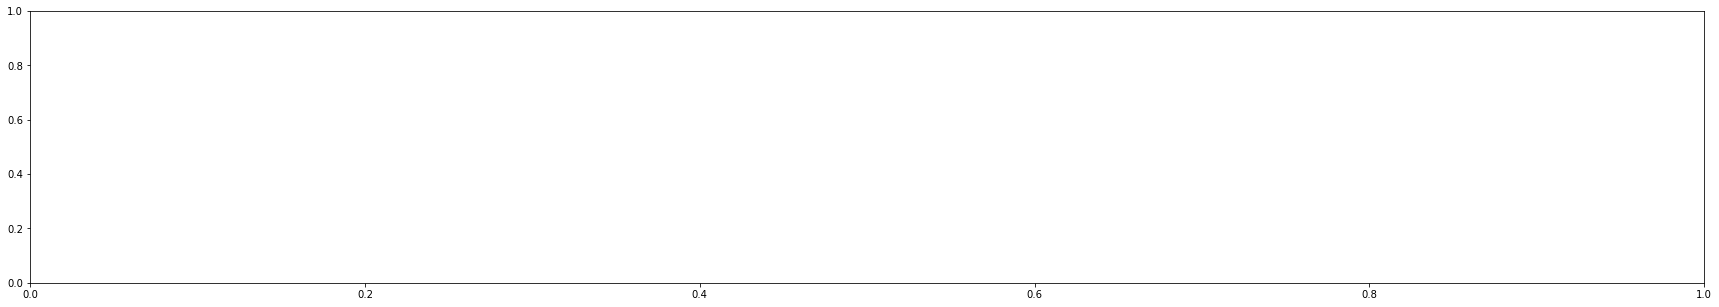

In [290]:
def plot_coverage_data(coverage_data):
    # Coverage over insertion sites
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x='variable', y='value', showfliers = False, data=coverage_data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_title('Coverage over insertion sites')
    
    # Insertion sites without coverage
    fig, ax = plt.subplots(figsize=(30, 5))
    germline_sites_without_coverage = coverage_data['value'].eq(0).astype(int).groupby(coverage_data['variable']).sum().sort_values(ascending=False)
    germline_sites_without_coverage.plot(kind='bar', x='sample', y='count', figsize=(20, 5), title='Number of insertion sites with no coverage per sample', ax=ax)

coverage_data = final_table.iloc[:, 11:-2].melt()
plot_coverage_data(coverage_data)

In [ ]:
coverage_data = final_table[final_table.median_coverage >= 10].iloc[:, 11:-1].melt()
plot_coverage_data(coverage_data)

In [ ]:
final_table

In [ ]:

final_table[final_table['early_developmental']]

In [ ]:
final_table[(~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [ ]:
final_table[(final_table['median_coverage'] >=10) & (~final_table['early_developmental']) & (final_table['private'])].insertion.value_counts().plot(kind='bar').set_title('Germline private TE insertions')

In [ ]:
final_table[(~final_table['early_developmental']) & (final_table['private']) & (final_table['insertion'] == 'copia')]

In [ ]:
final_table[3222:3224]['R11_gut']

In [ ]:
pd.set_option('display.max_columns', None)
final_table[final_table['H9_head'] == 0]

In [ ]:
final_table[final_table['R8_head'] == 0]

In [ ]:
final_table[final_table['median_coverage'] < 10]

In [ ]:
final_table.to_csv(FINAL_TABLE, sep='\t', index=None)

In [ ]:
final_table